# PINDER DockQ: efficient implementation of evaluation metrics

## Harnessing Biotite: the workhorse beind Pinder's abstractions



At the heart of `pinder` lies a strategic integration with the numpy-native biotite package. This integration allowed for the manipulation and operation of structural data at unparalleled efficiency. Through numpy's optimized array operations, `pinder` manages to handle large-scale data without compromising on speed, accuracy or ease of use.

## Evaluation harness: implementation of DockQ metrics

One of `pinder`'s core contributions has been the custom implementation of the gold-standard set of structural interface prediction quality metrics: __L<sub>rms</sup>__, __I<sub>rms</sub>__, __F<sub>nat</sub>__, __DockQ__ and the CAPRI classification. 

While I won't cover each of these metrics in detail in this notebook, I want to highlight the motivation and features of the DockQ implementation. This metric, essential in assessing the quality of protein-protein docking predictions, was first introduced by [Sankar Basu and Bjorn Wallner](https://github.com/bjornwallner/DockQ) in 2016, and has since remained the go-to metric for PPI prediction methodology benchmarks. The metric introduces a normalized quality measure that combines all of the metrics standardized by the CAPRI community to enable direct ranking of models, correlation with scoring functions and use as a target function in machine learning algorithms. 

Building off of the fantastic work in the original DockQ publication, we wanted to address several performance bottlenecks and reduce installation friction by introducing an OS-agnostic, python-native implementation of DockQ, leveraging the spectacular [biotite](https://github.com/biotite-dev/biotite) package.


### BiotiteDockQ: efficient implementation of evaluation metrics 

[Biotite](https://www.biotite-python.org/index.html) offers an extensive toolbox for working with sequence and structure data -- searching and fetching from biological databases, reading and writing popular file formats, analyzing, editing and visualizing, as well as interfacing external applications for further analysis.

The focus on performance and intuitive usability is ultimately what makes it my go-to tool for working with structural data, especially when writing `pinder`.

Internally, the majority of data is stored as __NumPy ndarray__ objects. In my opinion, the `AtomArray` and `AtomArrayStack` provide some of the most powerful constructs in the `biotite.structure` package.

The object hierarchy follows `AtomArrayStack` -> `AtomArray` -> `Atom`, where each parent contains an array of the child. 

Collections of euclidean coordinates are a natural match for numpy arrays. All of the other fields typically found in a PDB file format are effectively metadata that can be stored as annotations. The primitive base `Atom` object leverages these principles to enable an efficient storage and access mechanism: annotations are stored as scalar values and coordinates as length 3 ndarrays. When accessing slices of the data, there is no need for custom, un-optimized python implementations, as each of the fields can be accessed as numpy-native data structures. 

This property becomes especially powerful when you consider the `AtomArrayStack`. An `AtomArrayStack` stores data for `m` models, where each model contains the same atoms at different positions. Hence, the annotation arrays are represented as `ndarray` objects of length `n` like the `AtomArray`, while the coordinates are a `(m x n x 3) ndarray`. 

If you imagine a collection of decoys from a protein-protein docking method, you typically have a sequence of PDB files containing the same two proteins with one or more proteins in alternative conformations. As such, the only thing that is different about the structural models is the coordinate data -- a natural fit for the `AtomArrayStack`. Rather than storing separate copies of annotations for each model in memory, you store just a single set of annotation arrays in the same index order as the atoms in the collection of `AtomArray`'s in the stack. 

These properties combine to result in not only an intuitive means for accessing data through natural array indexing mechanisms, but also a major performance boost due to the ability to apply vectorized numpy methods. 

With these powerful constructs in place, the real bottleneck that remains is, perhaps unsurprisingly, **file I/O** -- each read of a PDB file requires streaming large amounts of text data. Thankfully, even these woes can be addressed in a number of ways:

1. Transitioning to the binary `MMTF` format, which features a smaller file size and a highly increased I/O operation performance, than text-based file formats. 
2. Adopting `fastpdb`, a high performance drop-in replacement for Biotite's PDBFile written in Rust.
3. Exploiting structural/geometric properties or representations of docking algorithms when possible.

I'd like to give a practical illustration of the third optimization to give a flavor for why the biotite package can be so powerful. 

It is common for protein-protein docking algorithms (especially rigid-body methods based on Fast-Fourier-Transforms) to internally represent the predictions as a set of mathematical operators. The basic premise is to represent the mobile, ligand-protein in a given model as a vector that encodes the translation and rotation. 

Although the specific encoding implementations may differ (euler angles, rotation matrices, quaternions, etc.), one common thread is the ability to efficiently store the model as a single vector which can be applied as an operation to the starting coordinates, reducing the need to store separate copies of the coordinates in memory or PDB files. Sadly, it is often necessary to write the final models as PDB files for use in downstream analyses or clustering schemes. 

**Below I illustrate how we can write a simple method for generating a "stack" of poses from a dataframe containing translation vectors and quaternions and a single atom array for the ligand protein:**

In [1]:
import numpy as np
import pandas as pd
from biotite.structure.atoms import AtomArray, AtomArrayStack
from numpy import ndarray
from scipy.spatial.transform import Rotation as R

def generate_pose_stack(ligand: AtomArray, operations: pd.DataFrame) -> AtomArrayStack:
    """Generate AtomArrayStack of ligand poses from 7-component vectors.

    Parameters
    ----------
    ligand : AtomArray
        Ligand protein biotite atom array centered at origin.
    operations : pd.DataFrame
        Dataframe containing translation vectors and rotation quaternions
        to transform ligand protein centered at origin to a pose.

        The dataframe must containg the following columns:
        `[tx, ty, tz, qw, qx, qy, qz]`

    Returns
    -------
    AtomArrayStack
        AtomArrayStack of shape `(operations.shape[0], ligand.shape[0], 3)`.

    """
    translations = operations[["tx", "ty", "tz"]].to_numpy()
    # quaternions in SciPy scalar last format (x, y, z, w)
    rotations = operations[["qx", "qy", "qz", "qw"]].to_numpy()
    # M poses
    M = translations.shape[0]
    # Inititalize an empty stack with shape (m x n x 3) 
    stack = AtomArrayStack(M, ligand.shape[0])
    # copy annotations from ligand
    for annot in ligand.get_annotation_categories():
        # Notice we are not repeating this for M models
        stack.set_annotation(annot, np.copy(ligand.get_annotation(annot)))
    # generate one pose at a time
    for i in range(M):
        q = R.from_quat(rotations[i, ...])
        stack.coord[i, ...] = q.apply(ligand.coord) + translations[i, ...]
    return stack

**Now to try it out in practice!**

Below, I will generate 20 random models of a ligand protein where each model follows a rotation about the z-axis using some quaternion math.

First, let's write a helper function to convert a rotation axis and angle into a quaternion:

In [2]:
import math

def quaternion_from_axis_angle(axis: ndarray, angle: float) -> ndarray:
    """
    Convert an axis-angle representation to a quaternion.

    Parameters:
        - axis: The axis of rotation as a 3D vector. Should be normalized.
        - angle: The angle of rotation in radians.

    Returns:
        - ndarray: A quaternion in SciPy scalar last format (x, y, z, w).
    """
    w = math.cos(angle / 2.0)
    x = axis[0] * math.sin(angle / 2.0)
    y = axis[1] * math.sin(angle / 2.0)
    z = axis[2] * math.sin(angle / 2.0)
    return np.array([x, y, z, w])

We first seed the rotation about the z-axis with a random quaternion:

In [3]:
# Random quaternion
q = R.random().as_quat()
# Axis to introduce rotations about (z-axis)
axis = np.array([0.0, 0.0, 1.0])
q

array([ 0.84616553, -0.31109981, -0.43114141, -0.03657735])

Now we will introduce 20 rotation angles about the axis to describe the "trajectory":

In [4]:
num_angles = 20
step_size = (2 * math.pi) / (num_angles - 1)
thetas = np.linspace(
    step_size, 2*math.pi,
    num=num_angles,
    endpoint=False
)
quaternions = []
for angle in thetas:
    axis_rot = quaternion_from_axis_angle(axis, angle)
    # Combine with base quaternion
    rot = (q * axis_rot)
    quaternions.append(rot)

Now that we have the rotations defined, lets encode them into a dataframe and add a random translation from the starting origin:


In [5]:
operations = pd.DataFrame([
    {'qx': q[0], 'qy': q[1], 'qz': q[2], 'qw': q[3], 'frame': i} 
    for i, q in enumerate(quaternions)
])
operations[['tx', 'ty', 'tz']] = [0.5, -0.5, 0.5]
operations

qx   qy        qz        qw  frame   tx   ty   tz
0   0.0 -0.0 -0.070964 -0.036078      0  0.5 -0.5  0.5
1   0.0 -0.0 -0.133230 -0.034787      1  0.5 -0.5  0.5
2   0.0 -0.0 -0.192552 -0.032727      2  0.5 -0.5  0.5
3   0.0 -0.0 -0.247617 -0.029943      3  0.5 -0.5  0.5
4   0.0 -0.0 -0.297209 -0.026498      4  0.5 -0.5  0.5
5   0.0 -0.0 -0.340231 -0.022466      5  0.5 -0.5  0.5
6   0.0 -0.0 -0.375733 -0.017938      6  0.5 -0.5  0.5
7   0.0 -0.0 -0.402929 -0.013014      7  0.5 -0.5  0.5
8   0.0 -0.0 -0.421219 -0.007802      8  0.5 -0.5  0.5
9   0.0 -0.0 -0.430199 -0.002417      9  0.5 -0.5  0.5
10  0.0 -0.0 -0.429669  0.003021     10  0.5 -0.5  0.5
11  0.0 -0.0 -0.419641  0.008392     11  0.5 -0.5  0.5
12  0.0 -0.0 -0.400338  0.013577     12  0.5 -0.5  0.5
13  0.0 -0.0 -0.372186  0.018463     13  0.5 -0.5  0.5
14  0.0 -0.0 -0.335806  0.022940     14  0.5 -0.5  0.5
15  0.0 -0.0 -0.292004  0.026911     15  0.5 -0.5  0.5
16  0.0 -0.0 -0.241747  0.030286     16  0.5 -0.5  0.5
17  0.0 -0.0 -0.186147  0.032992     17  0.5 -0.5  0.5
18  0.0 -0.0 -0.126432  0.034969     18  0.5 -0.5  0.5
19  0.0 -0.0 -0.063923  0.036173     19  0.5 -0.5  0.5

The operations dataframe can now be used in our `generate_pose_stack` function from before:

In [9]:
# Load an example PDB file into an AtomArray
from pinder.core.structure.atoms import atom_array_from_pdb_file
ligand = atom_array_from_pdb_file("af2_L.pdb")

stack = generate_pose_stack(ligand, operations)
stack.shape

(20, 7994)

While this is optional, I want to showcase some interesting applications of the plotly visualization package in this context. 

Below, I show how we can convert this `AtomArrayStack` into a dataframe that describes the trajectory, and adds additional metadata about the atoms -- their solvent accessible surface-area and Van Der Waals radii.

In [ ]:
import plotly
plotly.offline.init_notebook_mode()
import plotly.express as px
import biotite.structure as struc


stack_df = []
for i, model in enumerate(stack):
    # Lets color the atoms by their solvent accessibility and store the atomic VdW radii
    stack_df.extend([
        {
            'x': coord[0], 'y': coord[1], 'z': coord[2], 
            'sasa': sasa, 
            'vdw': struc.info.vdw_radius_protor(res_name, atom_name), 
            'frame': i
        }
        for coord, res_name, atom_name, sasa in zip(model.coord, model.res_name, model.atom_name, struc.sasa(model))
    ])


stack_df = pd.DataFrame(stack_df)
stack_df

**Visualize the trajectory!**

In [ ]:
stack_df.loc[:, "vdw_scale"] = stack_df.vdw - 1
fig = px.scatter_3d(
    stack_df,
    x="x", y="y", z="z", color="sasa",
    animation_frame="frame",
    template="plotly_dark",
    size="vdw_scale",
    range_x=[stack_df.x.min(), stack_df.x.max()],
    range_y=[stack_df.y.min(), stack_df.y.max()],
    range_z=[stack_df.z.min(), stack_df.z.max()],
    color_continuous_scale="tropic",
    opacity=1.0,

)
fig.update_traces(mode='markers', marker_line_width=0.1, marker_line_color="#171717")
# Hacks to improve animation player
btn1, btn2 = fig.layout.updatemenus[0].buttons
btn1.args[1]["visible"] = False
btn1.args[1]["frame"]["duration"] = 220  # buttons
btn2.args[1]["frame"]["duration"] = 220
btn2.args[1]["transition"]["duration"] = 0
btn2.args[1]["transition"]["duration"] = 0
fig.layout.updatemenus[0].buttons = btn1, btn2
fig.layout.sliders[0].steps[0].args[1]["frame"]["duration"] = 0  # slider
fig.update_scenes(aspectratio=dict(x=1, y=1, z=1))
fig.show()

### Comparison to original DockQ

Although we plan to extend the functionality of the `pinder.eval` package over time, I wanted to summarize some of the key benefits of the implementation:

1. Fully compliant with `pinder.core` dependencies
2. Python-native implementation (except for pip installable maturin-enabled rust extension `fastpdb`)
3. Adds additional features for tolerance to poor quality/homologous/misnumbered PDB files when comparing native and decoys, without a dependency on `needle` or `perl`
4. Major performance boosts by leveraging the
  i) Rust implementation of `biotite`'s `PDBFile` class, [fastpdb](https://github.com/biotite-dev/fastpdb), for fast PDB file I/O.
  ii) Numpy-native `AtomArray` and `AtomArrayStack` constructs in biotite, which provide vectorized primitives and efficient manipulation of atom annotations
  iii) Remove the need for multi-processing to get reasonable performance (or enabling multiprocessing over arbitrary number of systems to evaluate).



#### Regression tests
Regression tests are included with the `pinder` package for three different example systems taken from the [original repository](https://github.com/bjornwallner/DockQ). These examples also include three different combinations of chains as test-cases for the `1A2K` system.

Those tests are available in [test_dockq.py](https://github.com/pinder-org/pinder/blob/main/tests/test_dockq.py)





#### Performance speedup


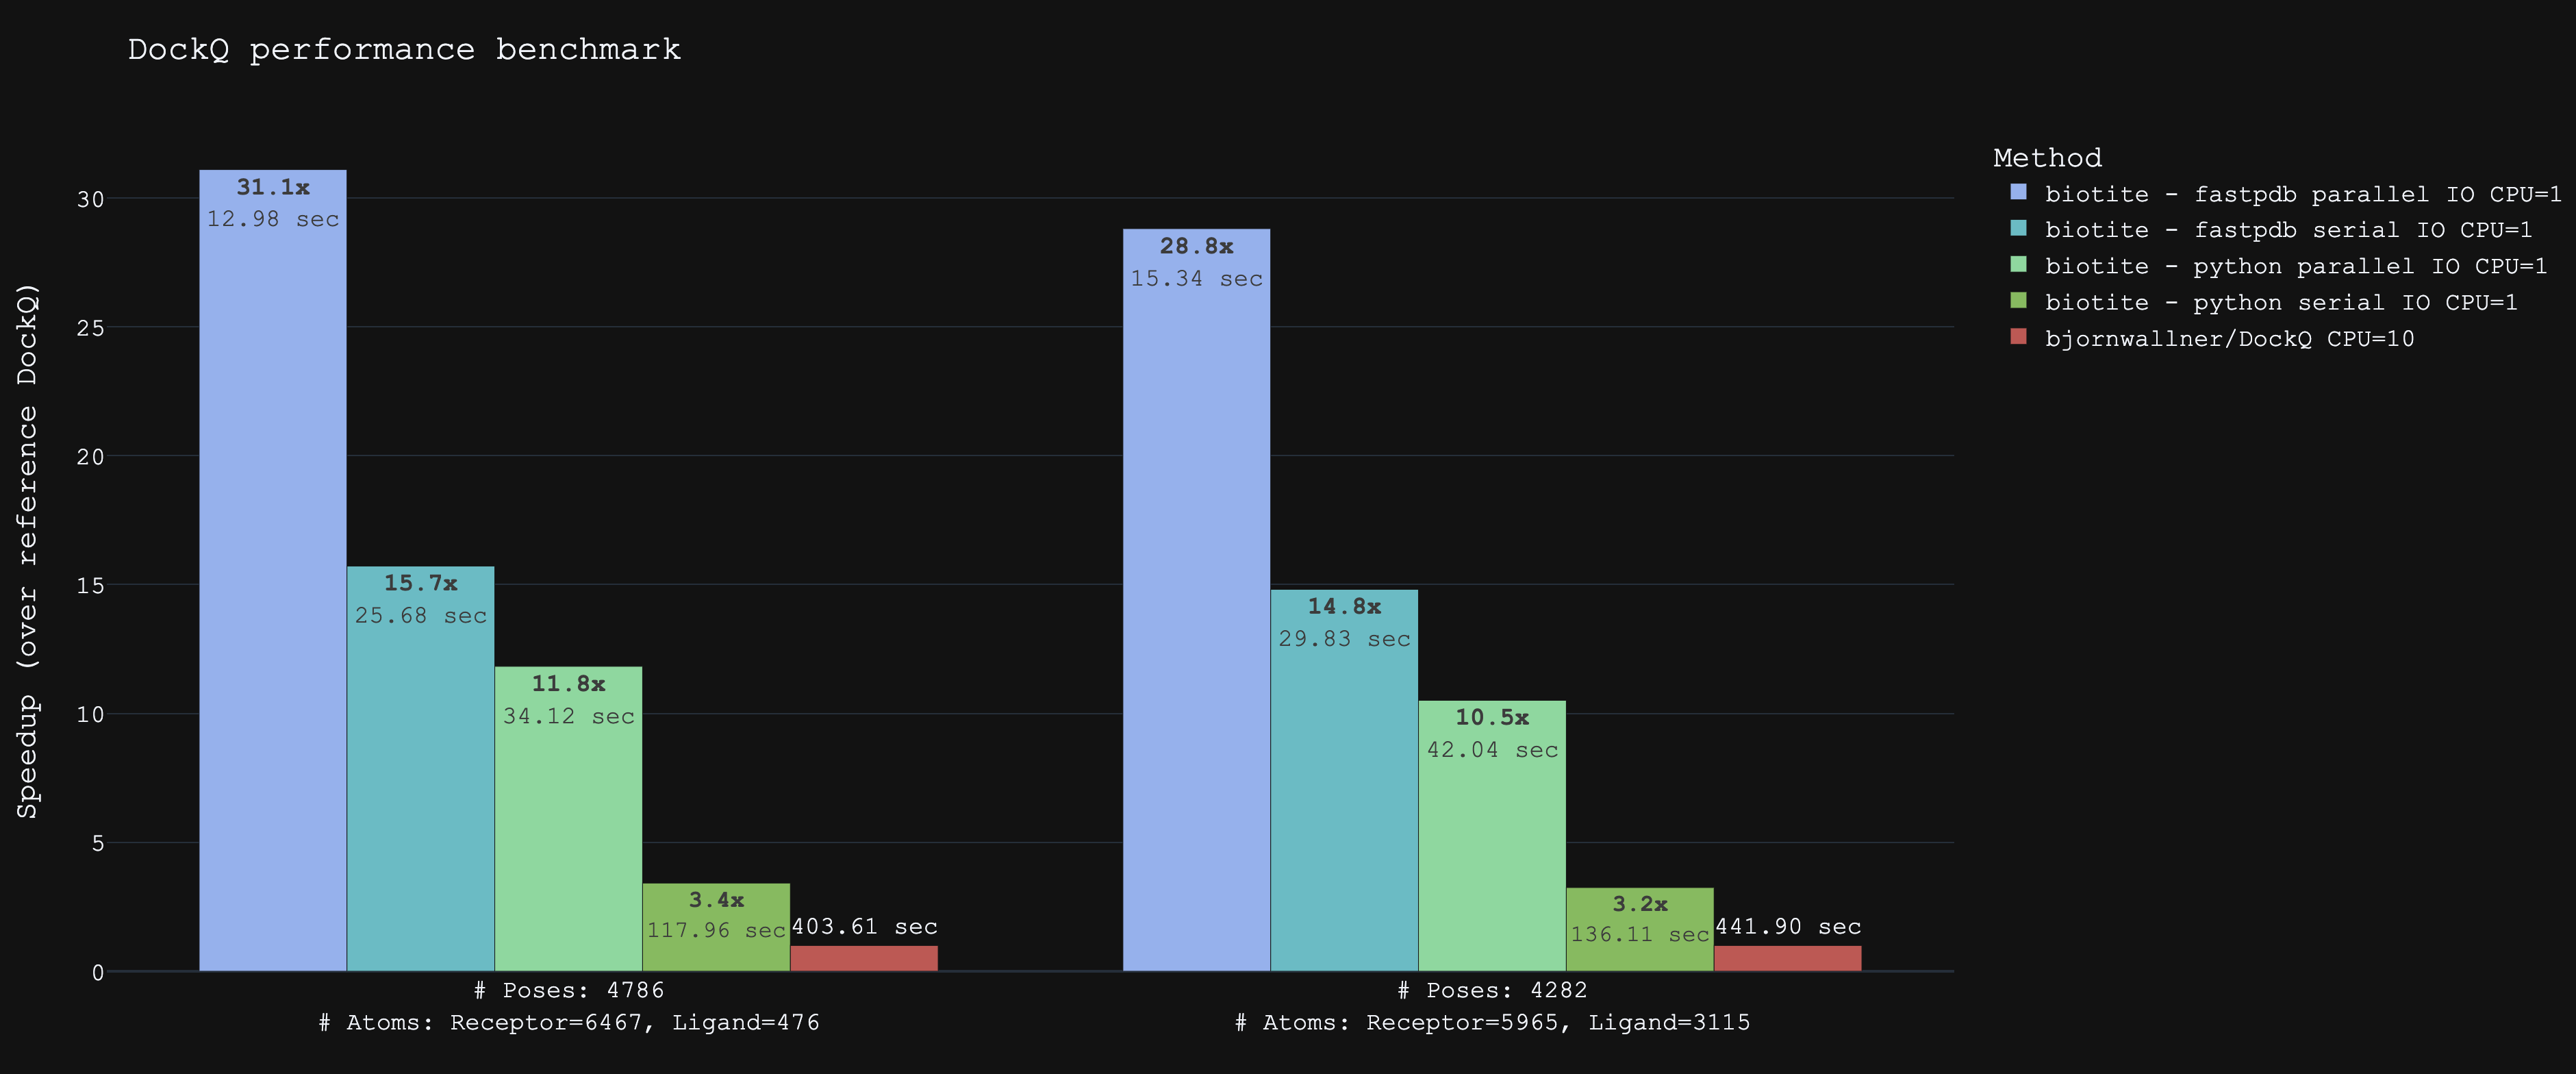

In [1]:
from IPython import display
import base64
from base64 import b64decode
from pathlib import Path

img_path = "../assets/dockq_performance_profile.png"

with open(img_path, "rb") as f:
    img_data = base64.b64encode(f.read())

display.Image(base64.b64decode(img_data))

#### Notes
It should be noted, some features like chain permutation remain to be explicitly implemented. However, this should already be possible by varying the constructor key-word arguments to BiotiteDockQ for specifying receptor and ligand chains.

##### Backbone definition
Biotite's definition of backbone is only considering linear backbone (N, CA, C) atoms, whereas the original DockQ implementation also includes oxygen.



The pinder implementation is made available through the `pinder.eval` namespace package. 

Below, the basic API is shown as a reference:

```python
from pinder.eval.dockq import BiotiteDockQ
bdq = BiotiteDockQ(native, models)
metrics = bdq.calculate()
```



## pinder_eval entrypoint

The evaluation harness can be used either through methods in `pinder.eval` or as a CLI script:


```
pinder_eval --help

usage: pinder_eval [-h] --eval_dir eval_dir [--serial] [--method_name method_name] [--allow_missing]

optional arguments:
  -h, --help            show this help message and exit
  --eval_dir eval_dir, -f eval_dir
                        Path to eval
  --serial, -s          Whether to disable parallel eval over systems
  --method_name method_name, -m method_name, -n method_name
                        Optional name for output csv
  --allow_missing, -a   Whether to allow missing systems for a given pinder-set + monomer

```

The expected format for the contents of `eval_dir` are shown below:
```
eval_dir_example/
└── some_method
    ├── 1ldt__A1_P00761--1ldt__B1_P80424
    │   ├── apo_decoys
    │   │   ├── model_1.pdb
    │   │   └── model_2.pdb
    │   ├── holo_decoys
    │   │   ├── model_1.pdb
    │   │   └── model_2.pdb
    │   └── predicted_decoys
    │       ├── model_1.pdb
    │       └── model_2.pdb
    └── 1b8m__B1_P34130--1b8m__A1_P23560
        ├── holo_decoys
        │   ├── model_1.pdb
        │   └── model_2.pdb
        └── predicted_decoys
            ├── model_1.pdb
            └── model_2.pdb
```

The eval directory should contain one or more methods to evaluate as sub-directories.

Each method sub-directory should contains sub-directories that are named by pinder system ID.

Inside of each pinder system sub-directory, you should have three subdirectories:
* `holo_decoys` (predictions that were made using holo monomers)
* `apo_decoys` (predictions made using apo monomers)
* `predicted_decoys` (predictions made using predicted, e.g. AF2, monomers)

You can have any number of decoys in each directory; however, the decoys should be named in a way that the prediction rank can be extracted. In the above example, the decoys are named using a `model_<rank>.pdb` convention. Other names for decoy models are accepted, so long as they can match the regex pattern used in `pinder.eval.dockq.MethodMetrics`: `r"\d+(?=\D*$)"`

Each model decoy should have exactly two chains: {R, L} for {Receptor, Ligand}, respectively.


⚠️ **Note: in order to make a fair comparison of methods across complete test sets, if a method is missing predictions for a system, the following metrics are used as a penalty**

```python

{
    "iRMS": 100.0,
    "LRMS": 100.0,
    "Fnat": 0.0,
    "DockQ": 0.0,
    "CAPRI": "Incorrect",
}
```


Under the hood, the leaderboard makes use of the `MethodMetrics` class from the `pinder.eval.dockq.method`. This interface is itself an abstraction over the underlying `BiotiteDockQ` API. 

Below I show an example of how you could use the `BiotiteDockQ` class directly. 

In [8]:
from pathlib import Path
from pinder.eval.dockq.biotite_dockq import BiotiteDockQ

method_dir = Path("../tests/test_data/method_eval/geodock")
system = method_dir / "2e31__A1_Q80UW2--2e31__B1_P63208"

native = system / f"{system.stem}.pdb"
decoys = list((system / "holo_decoys").glob("*.pdb"))

R_chain, L_chain = ["R"], ["L"]
bdq = BiotiteDockQ(
    native=native, decoys=decoys,
    # These are optional and if not specified will be assigned based on number of atoms (receptor > ligand)
    native_receptor_chain=R_chain,
    native_ligand_chain=L_chain,
    decoy_receptor_chain=R_chain,
    decoy_ligand_chain=L_chain,
)
metrics = bdq.calculate()
metrics


2024-04-25 20:36:20,068 | pinder.eval.dockq.biotite_dockq.read_decoys:25 | INFO : runtime succeeded:     10.07s
2024-04-25 20:36:20,305 | pinder.eval.dockq.biotite_dockq.set_common:25 | INFO : runtime succeeded:      0.00s
2024-04-25 20:36:20,324 | pinder.eval.dockq.biotite_dockq.get_decoy_contacts:25 | INFO : runtime succeeded:      0.01s


model_name                       native_name  \
0    model_1  2e31__A1_Q80UW2--2e31__B1_P63208   

                             system   method model_folder     iRMS       LRMS  \
0  2e31__A1_Q80UW2--2e31__B1_P63208  geodock  holo_decoys  7.70684  21.733768   

   Fnat     DockQ      CAPRI  decoy_contacts  native_contacts  \
0  0.03  0.066388  Incorrect              54              100   

   initial_decoy_shape  final_decoy_shape  initial_native_shape  \
0                 1870               1870                  3055   

   final_native_shape  
0                3055


## References
[1]
P. Kunzmann, K. Hamacher, "Biotite: a unifying open source computational biology framework in Python," BMC Bioinformatics, vol. 19, pp. 346, October 2018. doi: 10.1186/s12859-018-2367-z

[2] S. Basu, B. Wallner, "DockQ: A Quality Measure for Protein-Protein Docking Models", PLOS ONE,  doi:10.1371/journal.pone.0161879
